<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Imperial_College_London_new_logo.png" alt="Imperial Logo" width="400">

### **Course:** CIVE70111 Machine Learning
### Task 2 Plant Modelling and Machine Learning Pipeline

**Project:** Task 5

**Date:** 09/12/2025  

<p align="right">
Created by: WEIYI BAO

# Contents

1. Aim of Task 5  
2. Data and Pre-processing  
3. Helper Functions (Loading and Feature Engineering)  
4. Random Forest Regression Helper Functions  
5. Plant 1 – DC and AC Random Forest Models  
6. Plant 2 – DC and AC Random Forest Models  
7. PDP-Based Global Effects  
8. Summary and Discussion  



# 1. Aim of Task 5

The aim of this task is to build and interpret **Random Forest regression models** for the PV plants:

- For **Plant 1** and **Plant 2**, combine all inverters into a single dataset per plant.
- Predict:
  - `DC_CLEAN` – cleaned DC power,
  - `AC_CLEAN` – cleaned AC power.
- Use common engineered features:
  - `IRRADIATION_CLEAN`
  - ambient and module temperatures, temperature difference
  - daily and total yields
  - counts of optimal/suboptimal operating conditions
  - time-of-day (cyclical encoding).
- Interpret the models using:
  - **Permutation importance** (drop in negative MSE),
  - **SHAP waterfall plots** (local feature contributions),
  - **Residualisation-based coefficients** (approximate marginal effects),
  - (Optional) **PDP-based slopes** as a global measure of feature effect.


# 2. Imports & Paths



In [ ]:
# Imports and configuration for Task 5

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.linear_model import LinearRegression

import shap

# Optional: nicer display
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

# Base folders for cleaned daily inverter data (adapt if paths change)

##################################################################################################################################################################################
# Folder

BASE_DAILY_FOLDER_P1 = r"C:\Users\B.KING\OneDrive - Imperial College London\CIVE70111 Machine Learning\CouseWork\Group-11\data\00 Excel clean file\Plant 1\Daily_Inverter_Data"
BASE_DAILY_FOLDER_P2 = r"C:\Users\B.KING\OneDrive - Imperial College London\CIVE70111 Machine Learning\CouseWork\Group-11\data\00 Excel clean file\Plant 2\Daily_Inverter_Data"

##################################################################################################################################################################################

# Common date range (consistent with previous tasks)
START = pd.to_datetime("2020-05-15")
END   = pd.to_datetime("2020-06-17")


# 3. Helper Functions – Loading and Feature Engineering



In [2]:
def get_inverter_dirs(base_folder):
    """
    Return a sorted list of inverter subfolders inside base_folder.
    Each subfolder corresponds to a different SOURCE_KEY.
    """
    dirs = [
        d for d in glob.glob(os.path.join(base_folder, "*"))
        if os.path.isdir(d)
    ]
    if not dirs:
        raise FileNotFoundError(
            f"No inverter subfolders found in {base_folder}. "
            "Check BASE_DAILY_FOLDER path."
        )
    return sorted(dirs)


def load_and_clean_csv(path):
    """
    Load a single CSV file and apply basic cleaning + date filter:
    - Parse DATE_TIME
    - Restrict to [START, END]
    - Interpolate numeric columns and fill any remaining gaps
    """
    df = pd.read_csv(path)
    df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])
    df = df[(df["DATE_TIME"] >= START) & (df["DATE_TIME"] <= END)]
    df = df.interpolate().ffill().bfill()
    return df


def load_all_plant(base_folder, plant_name="Plant"):
    """
    Load and combine all inverters for a given plant into a single DataFrame.

    Expected folder structure:
        base_folder/<SOURCE_KEY>/*.csv
    """
    inverter_dirs = get_inverter_dirs(base_folder)
    frames = []

    for inv_dir in inverter_dirs:
        source_key = os.path.basename(inv_dir)
        files = sorted(glob.glob(os.path.join(inv_dir, "*.csv")))
        if not files:
            print(f"[WARN] No CSV files in {inv_dir}")
            continue

        daily = []
        for f in files:
            df = load_and_clean_csv(f)
            if not df.empty:
                df["SOURCE_KEY"] = source_key
                daily.append(df)

        if daily:
            df_inv = pd.concat(daily, ignore_index=True)
            frames.append(df_inv)
            print(f"[INFO] {plant_name} – {source_key}: {len(df_inv)} rows")

    if not frames:
        raise ValueError(f"No {plant_name} inverter data loaded.")

    df_all = pd.concat(frames, ignore_index=True)
    print(f"\n[INFO] Combined {plant_name} dataset shape: {df_all.shape}")
    return df_all


def engineer_features(df_all: pd.DataFrame, plant_name="Plant"):
    """
    Engineer common features used for DC/AC regression:

      - IRRADIATION_CLEAN
      - AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, Temp_Delta
      - DAILY_YIELD_CLEAN, TOTAL_YIELD_CLEAN
      - NUM_OPT, NUM_SUBOPT
      - hour_sin, hour_cos (cyclical time-of-day)

    Targets (kept separate, not included as features):
      - DC_CLEAN (for DC model)
      - AC_CLEAN (for AC model)
    """
    df = df_all.copy()

    # Time features
    df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])
    df["hour"] = df["DATE_TIME"].dt.hour + df["DATE_TIME"].dt.minute / 60.0
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)

    # Temperature delta
    df["Temp_Delta"] = df["MODULE_TEMPERATURE"] - df["AMBIENT_TEMPERATURE"]

    # Feature list (no DC/AC themselves as inputs)
    candidate_features = [
        "IRRADIATION_CLEAN",
        "AMBIENT_TEMPERATURE",
        "MODULE_TEMPERATURE",
        "Temp_Delta",
        "DAILY_YIELD_CLEAN",
        "TOTAL_YIELD_CLEAN",
        "NUM_OPT",
        "NUM_SUBOPT",
        "hour_cos",
        "hour_sin",
    ]

    feature_cols = [c for c in candidate_features if c in df.columns]
    if not feature_cols:
        raise ValueError(f"No valid feature columns found in {plant_name} data.")

    # Targets
    for col in ["DC_CLEAN", "AC_CLEAN"]:
        if col not in df.columns:
            raise KeyError(f"Missing target column '{col}' in {plant_name} data.")

    X = df[feature_cols]
    y_dc = df["DC_CLEAN"]
    y_ac = df["AC_CLEAN"]

    print(f"\n[INFO] Using feature columns ({plant_name}):")
    for c in feature_cols:
        print("  -", c)

    return X, y_dc, y_ac, feature_cols


# 4. Random Forest Regression Helper Functions



In [3]:
def train_rf(X_train, y_train):
    """
    Train a RandomForestRegressor with fixed hyperparameters.
    """
    rf = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    return rf


def permutation_importance_plot(model, X_test, y_test, feature_names, title_suffix):
    """
    Compute permutation importance (scoring='neg_mean_squared_error') and
    plot a horizontal bar chart.
    """
    result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=20,
        scoring="neg_mean_squared_error",
        random_state=42,
        n_jobs=-1
    )

    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": result.importances_mean
    }).sort_values("importance", ascending=True)

    print(f"\n=== Permutation Importance (neg MSE) – {title_suffix} ===")
    display(imp_df.sort_values("importance", ascending=False))

    plt.figure(figsize=(7, 8))
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.xlabel("Mean Importance (drop in negative MSE)")
    plt.title(f"Random Forest Permutation Importance – {title_suffix}")
    plt.tight_layout()
    plt.show()


def shap_waterfall_plots(rf_dc, rf_ac, X_test, feature_names, plant_label="Plant"):
    """
    Create SHAP waterfall plots for DC and AC models using a small
    sample of the test set, with titles.
    """
    print("\n=== SHAP waterfall plots –", plant_label, "===")

    # Use a small sample for speed
    if hasattr(X_test, "sample"):
        X_shap = X_test.sample(min(200, len(X_test)), random_state=0)
    else:
        X_shap = X_test

    # Ensure DataFrame for nice labels
    if not isinstance(X_shap, pd.DataFrame):
        X_shap = pd.DataFrame(X_shap, columns=feature_names)

    # ---- DC model SHAP ----
    print("Computing SHAP values for DC model...")
    explainer_dc = shap.TreeExplainer(rf_dc)
    shap_values_dc = explainer_dc(X_shap)

    shap.plots.waterfall(shap_values_dc[0], max_display=10)
    plt.title(f"{plant_label} – SHAP Waterfall (DC Forecasting Model)")
    plt.tight_layout()
    plt.show()

    # ---- AC model SHAP ----
    print("Computing SHAP values for AC model...")
    explainer_ac = shap.TreeExplainer(rf_ac)
    shap_values_ac = explainer_ac(X_shap)

    shap.plots.waterfall(shap_values_ac[0], max_display=10)
    plt.title(f"{plant_label} – SHAP Waterfall (AC Forecasting Model)")
    plt.tight_layout()
    plt.show()

def residual_coefficients_rf(
    X,
    y,
    feature_names,
    n_estimators=200,
    n_max=2000,
    random_state=42,
    n_jobs=-1,
):
    """
    Approximate per-feature 'coefficients' for a Random Forest using
    residualisation.

      For each feature z in feature_names:
        1. Let x = all other features.
        2. Fit RF: y ~ x  -> y_hat.
        3. Compute residuals: r = y - y_hat.
        4. Fit linear model: r ~ z.
        5. The slope (beta) is a coefficient-like effect of z given x.

    We subsample up to n_max rows for speed.
    """
    # Make sure X is a DataFrame with a clean 0..n-1 index
    X = pd.DataFrame(X, columns=feature_names).reset_index(drop=True)

    # y as numpy array, aligned with X by position
    y = np.asarray(y)

    # Subsample for speed
    if len(X) > n_max:
        X_sample = X.sample(n_max, random_state=random_state)
        # After reset_index, X.index is 0..len-1, so this is safe:
        idx = X_sample.index.to_numpy()
        y_sample = y[idx]
    else:
        X_sample = X.copy()
        y_sample = y.copy()

    rows = []
    for z_name in feature_names:
        other_feats = [f for f in feature_names if f != z_name]
        X_other = X_sample[other_feats]
        z = X_sample[[z_name]]

        # RF on all features except z
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=n_jobs
        )
        rf.fit(X_other, y_sample)
        y_hat = rf.predict(X_other)

        # Residuals
        r = y_sample - y_hat

        # Linear regression: r ~ z
        lin = LinearRegression()
        lin.fit(z, r)
        beta = float(lin.coef_[0])

        rows.append({
            "feature": z_name,
            "beta": beta,
            "abs_beta": abs(beta)
        })

    coef_df = pd.DataFrame(rows).sort_values("abs_beta", ascending=False)
    return coef_df

   


# 5. Plant 1 – DC and AC Random Forest Models



=== PLANT 1: Load & combine all inverters ===
[INFO] Plant 1 – 1BY6WEcLGh8j5v7: 3061 rows
[INFO] Plant 1 – 1IF53ai7Xc0U56Y: 3025 rows
[INFO] Plant 1 – 3PZuoBAID5Wc2HD: 3025 rows
[INFO] Plant 1 – 7JYdWkrLSPkdwr4: 3040 rows
[INFO] Plant 1 – McdE0feGgRqW7Ca: 3031 rows
[INFO] Plant 1 – VHMLBKoKgIrUVDU: 3040 rows
[INFO] Plant 1 – WRmjgnKYAwPKWDb: 3025 rows
[INFO] Plant 1 – YxYtjZvoooNbGkE: 3011 rows
[INFO] Plant 1 – ZnxXDlPa8U1GXgE: 3037 rows
[INFO] Plant 1 – ZoEaEvLYb1n2sOq: 3030 rows
[INFO] Plant 1 – adLQvlD726eNBSB: 3025 rows
[INFO] Plant 1 – bvBOhCH3iADSZry: 3062 rows
[INFO] Plant 1 – iCRJl6heRkivqQ3: 3032 rows
[INFO] Plant 1 – ih0vzX44oOqAx2f: 3037 rows
[INFO] Plant 1 – pkci93gMrogZuBj: 3032 rows
[INFO] Plant 1 – rGa61gmuvPhdLxV: 3031 rows
[INFO] Plant 1 – sjndEbLyjtCKgGv: 3031 rows
[INFO] Plant 1 – uHbuxQJl8lW7ozc: 3032 rows
[INFO] Plant 1 – wCURE6d3bPkepu2: 3032 rows
[INFO] Plant 1 – z9Y9gH1T5YWrNuG: 3032 rows
[INFO] Plant 1 – zBIq5rxdHJRwDNY: 3026 rows
[INFO] Plant 1 – zVJPv84UY57b

,feature,importance
0,IRRADIATION_CLEAN,3.103232e+07
4,DAILY_YIELD_CLEAN,4.499061e+05
1,AMBIENT_TEMPERATURE,2.144959e+05
6,hour_sin,9.488981e+04
2,MODULE_TEMPERATURE,3.577626e+04
3,Temp_Delta,2.637828e+04
5,hour_cos,1.081985e+04


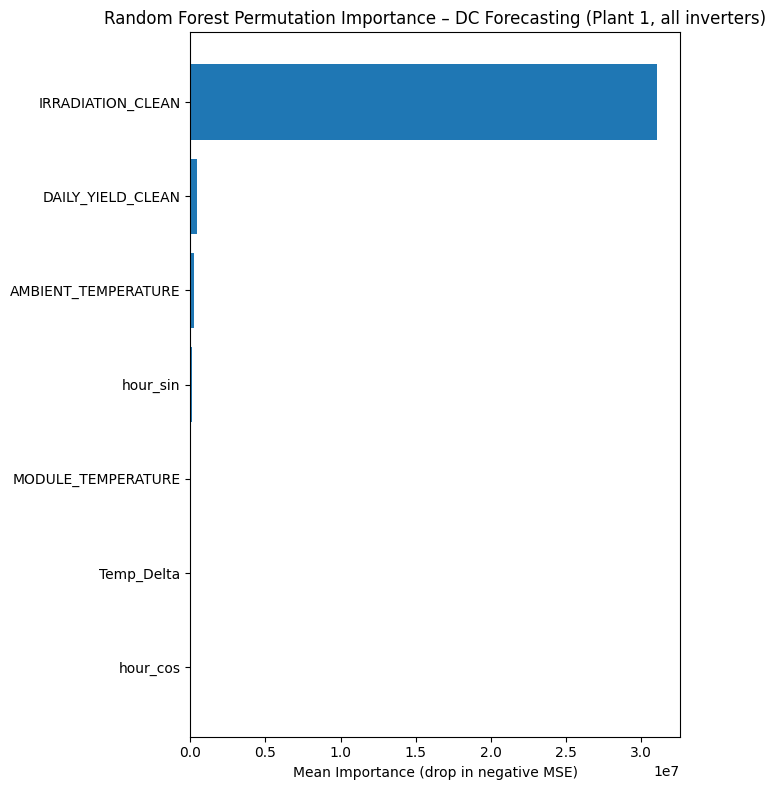


=== PLANT 1: Train Random Forest – AC_CLEAN ===
Plant 1 AC model Test R²: 0.9901

=== PLANT 1: Permutation importance – AC ===

=== Permutation Importance (neg MSE) – AC Forecasting (Plant 1, all inverters) ===


,feature,importance
0,IRRADIATION_CLEAN,296573.495413
4,DAILY_YIELD_CLEAN,4240.157710
1,AMBIENT_TEMPERATURE,1966.782183
6,hour_sin,901.843620
2,MODULE_TEMPERATURE,349.739738
3,Temp_Delta,258.492135
5,hour_cos,96.608973


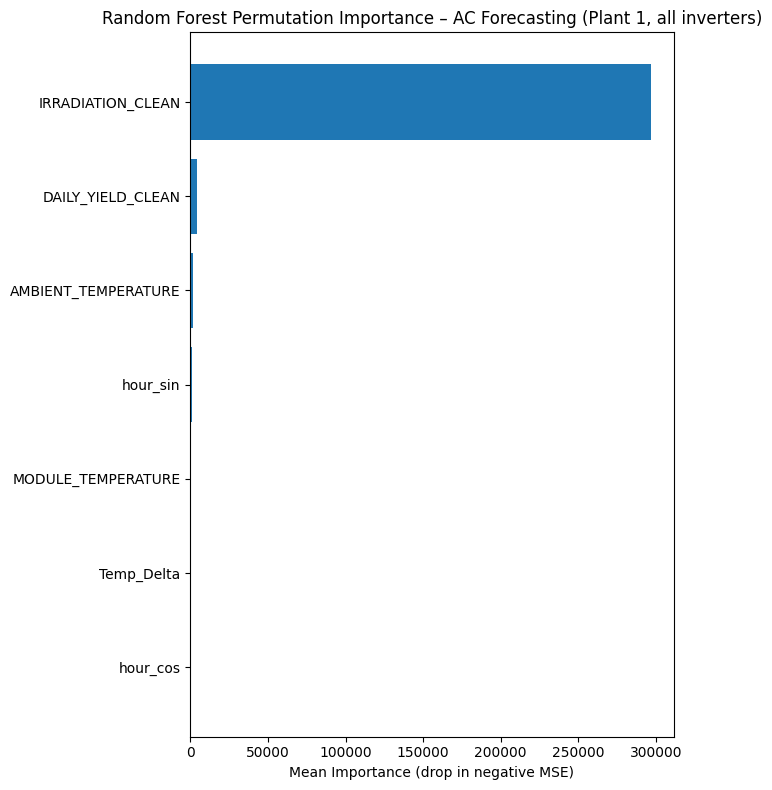


=== SHAP waterfall plots – Plant 1 ===
Computing SHAP values for DC model...


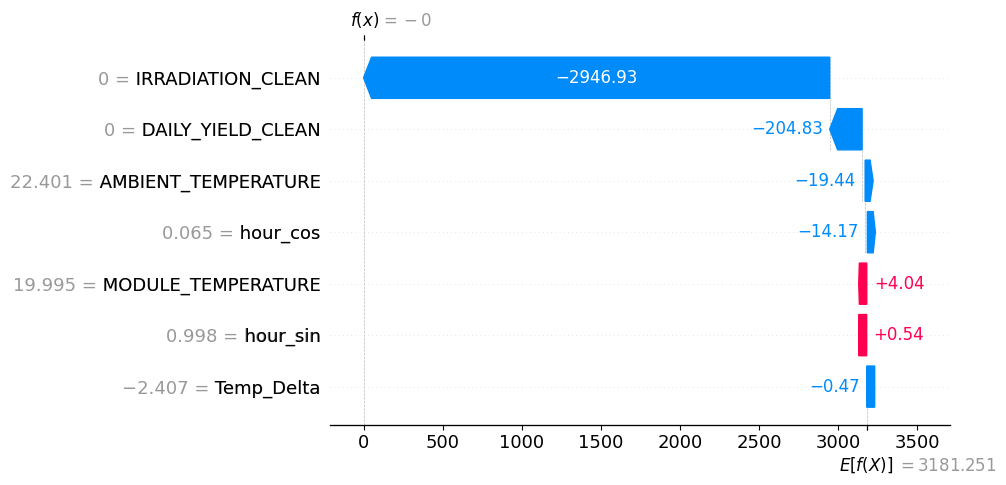

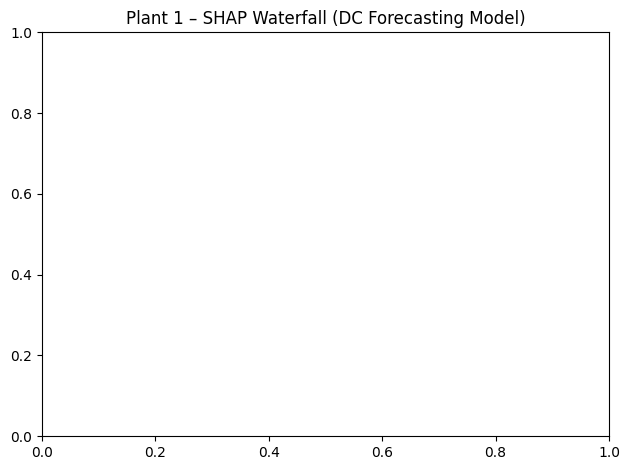

Computing SHAP values for AC model...


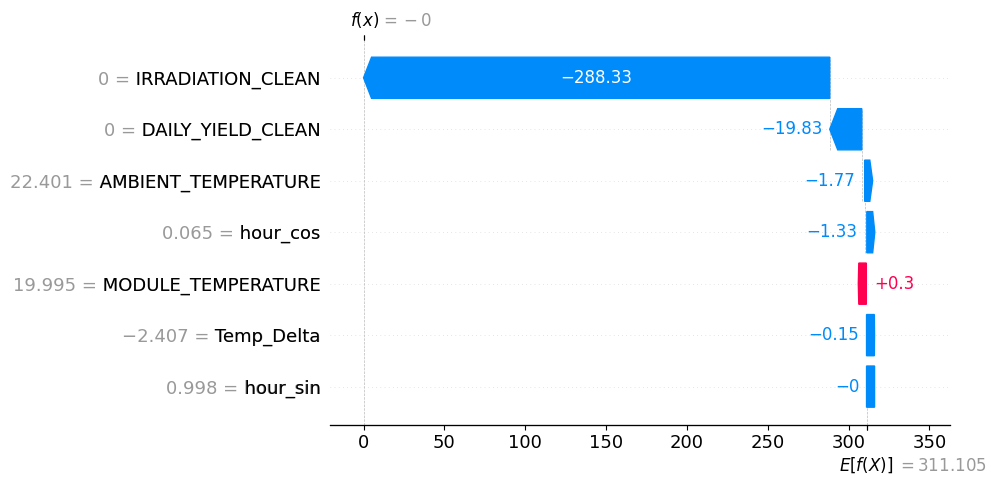

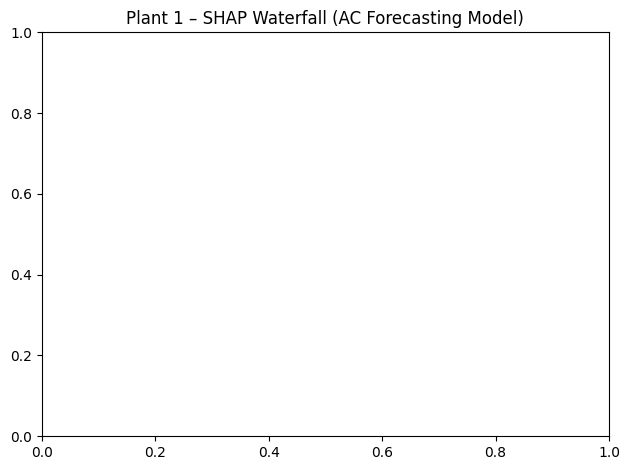


=== PLANT 1: Coefficient-like effects via residualisation – DC ===


,feature,beta,abs_beta
0,IRRADIATION_CLEAN,137.623615,137.623615
5,hour_cos,-9.571695,9.571695
6,hour_sin,-1.245653,1.245653
3,Temp_Delta,0.595009,0.595009
2,MODULE_TEMPERATURE,0.432690,0.432690
1,AMBIENT_TEMPERATURE,0.137473,0.137473
4,DAILY_YIELD_CLEAN,0.001743,0.001743



=== PLANT 1: Coefficient-like effects via residualisation – AC ===


,feature,beta,abs_beta
0,IRRADIATION_CLEAN,13.229826,13.229826
5,hour_cos,-0.899858,0.899858
6,hour_sin,-0.144042,0.144042
3,Temp_Delta,0.065469,0.065469
2,MODULE_TEMPERATURE,0.047638,0.047638
1,AMBIENT_TEMPERATURE,0.019715,0.019715
4,DAILY_YIELD_CLEAN,0.000173,0.000173


In [4]:
# -----------------------------
# Plant 1 – load and features
# -----------------------------
print("\n=== PLANT 1: Load & combine all inverters ===")
df_p1 = load_all_plant(BASE_DAILY_FOLDER_P1, plant_name="Plant 1")

print("\n=== PLANT 1: Feature engineering ===")
X_p1, y_dc_p1, y_ac_p1, feat_cols_p1 = engineer_features(df_p1, plant_name="Plant 1")

print("\n=== PLANT 1: Train/test split (shared for DC & AC) ===")
X1_train, X1_test, y1_dc_train, y1_dc_test, y1_ac_train, y1_ac_test = train_test_split(
    X_p1, y_dc_p1, y_ac_p1, test_size=0.2, random_state=42
)

# -----------------------------
# Plant 1 – DC model
# -----------------------------
print("\n=== PLANT 1: Train Random Forest – DC_CLEAN ===")
rf_dc_p1 = train_rf(X1_train, y1_dc_train)
print(f"Plant 1 DC model Test R²: {rf_dc_p1.score(X1_test, y1_dc_test):.4f}")

print("\n=== PLANT 1: Permutation importance – DC ===")
permutation_importance_plot(
    rf_dc_p1, X1_test, y1_dc_test, feat_cols_p1,
    "DC Forecasting (Plant 1, all inverters)"
)

# -----------------------------
# Plant 1 – AC model
# -----------------------------
print("\n=== PLANT 1: Train Random Forest – AC_CLEAN ===")
rf_ac_p1 = train_rf(X1_train, y1_ac_train)
print(f"Plant 1 AC model Test R²: {rf_ac_p1.score(X1_test, y1_ac_test):.4f}")

print("\n=== PLANT 1: Permutation importance – AC ===")
permutation_importance_plot(
    rf_ac_p1, X1_test, y1_ac_test, feat_cols_p1,
    "AC Forecasting (Plant 1, all inverters)"
)

# -----------------------------
# Plant 1 – SHAP and coefficients
# -----------------------------
shap_waterfall_plots(rf_dc_p1, rf_ac_p1, X1_test, feat_cols_p1, plant_label="Plant 1")

print("\n=== PLANT 1: Coefficient-like effects via residualisation – DC ===")
coef_dc_p1 = residual_coefficients_rf(X1_train, y1_dc_train, feat_cols_p1)
display(coef_dc_p1)

print("\n=== PLANT 1: Coefficient-like effects via residualisation – AC ===")
coef_ac_p1 = residual_coefficients_rf(X1_train, y1_ac_train, feat_cols_p1)
display(coef_ac_p1)


# 6. Plant 2 – DC and AC Random Forest Models




=== PLANT 2: Load & combine all inverters ===
[INFO] Plant 2 – 4UPUqMRk7TRMgml: 3100 rows
[INFO] Plant 2 – 81aHJ1q11NBPMrL: 3164 rows
[INFO] Plant 2 – 9kRcWv60rDACzjR: 3164 rows
[INFO] Plant 2 – Et9kgGMDl729KT4: 3100 rows
[INFO] Plant 2 – IQ2d7wF4YD8zU1Q: 2260 rows
[INFO] Plant 2 – LYwnQax7tkwH5Cb: 3164 rows
[INFO] Plant 2 – LlT2YUhhzqhg5Sw: 3164 rows
[INFO] Plant 2 – Mx2yZCDsyf6DPfv: 3100 rows
[INFO] Plant 2 – NgDl19wMapZy17u: 2260 rows
[INFO] Plant 2 – PeE6FRyGXUgsRhN: 3164 rows
[INFO] Plant 2 – Qf4GUc1pJu5T6c6: 3100 rows
[INFO] Plant 2 – Quc1TzYxW2pYoWX: 3100 rows
[INFO] Plant 2 – V94E5Ben1TlhnDV: 3164 rows
[INFO] Plant 2 – WcxssY2VbP4hApt: 3164 rows
[INFO] Plant 2 – mqwcsP2rE7J0TFp: 2260 rows
[INFO] Plant 2 – oZ35aAeoifZaQzV: 3100 rows
[INFO] Plant 2 – oZZkBaNadn6DNKz: 3164 rows
[INFO] Plant 2 – q49J1IKaHRwDQnt: 3164 rows
[INFO] Plant 2 – rrq4fwE8jgrTyWY: 3164 rows
[INFO] Plant 2 – vOuJvMaM2sgwLmb: 3164 rows
[INFO] Plant 2 – xMbIugepa2P7lBB: 2260 rows
[INFO] Plant 2 – xoJJ8DcxJEcu

,feature,importance
0,IRRADIATION_CLEAN,213424.110687
4,DAILY_YIELD_CLEAN,32883.091547
6,hour_sin,7621.887730
1,AMBIENT_TEMPERATURE,4504.229848
2,MODULE_TEMPERATURE,2897.765150
3,Temp_Delta,1548.946884
5,hour_cos,1384.921049


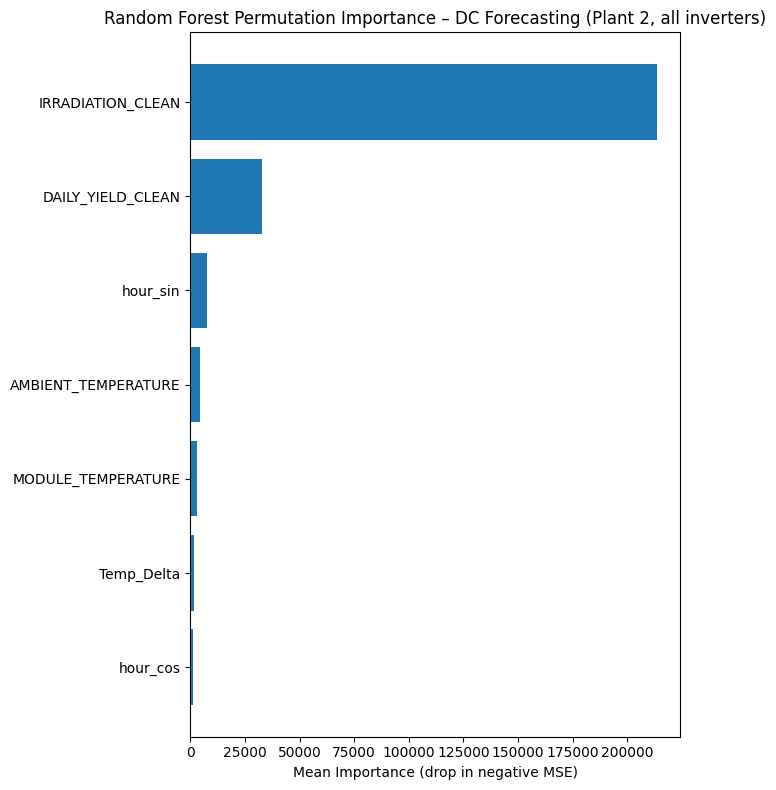


=== PLANT 2: Train Random Forest – AC_CLEAN ===
Plant 2 AC model Test R²: 0.9567

=== PLANT 2: Permutation importance – AC ===

=== Permutation Importance (neg MSE) – AC Forecasting (Plant 2, all inverters) ===


,feature,importance
0,IRRADIATION_CLEAN,203911.344068
4,DAILY_YIELD_CLEAN,31263.067834
6,hour_sin,7204.062900
1,AMBIENT_TEMPERATURE,4475.588432
2,MODULE_TEMPERATURE,2911.108916
3,Temp_Delta,1472.497225
5,hour_cos,1386.833509


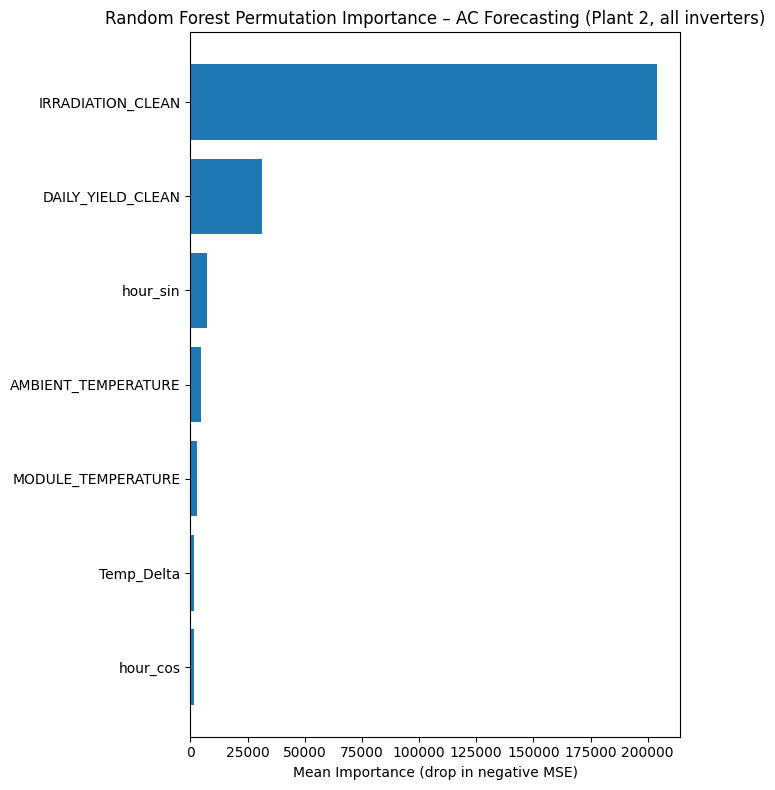


=== SHAP waterfall plots – Plant 2 ===
Computing SHAP values for DC model...


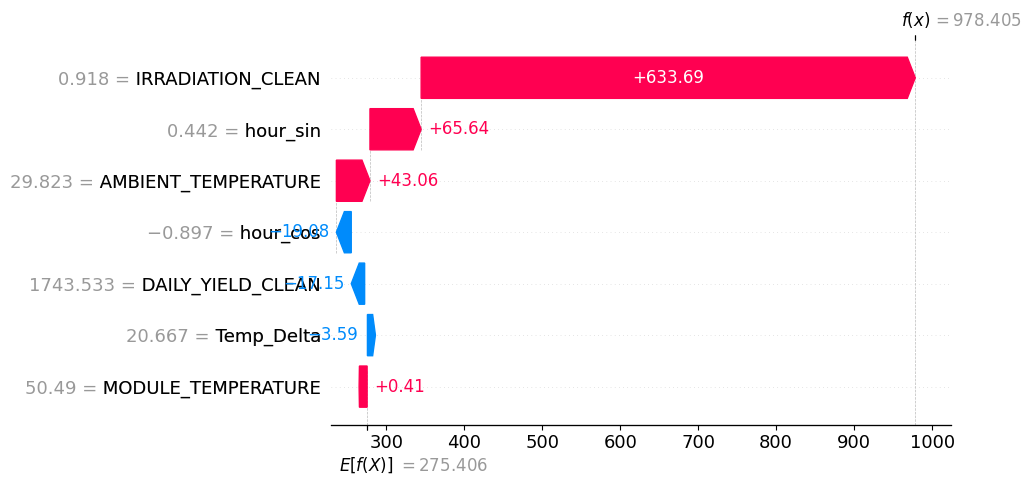

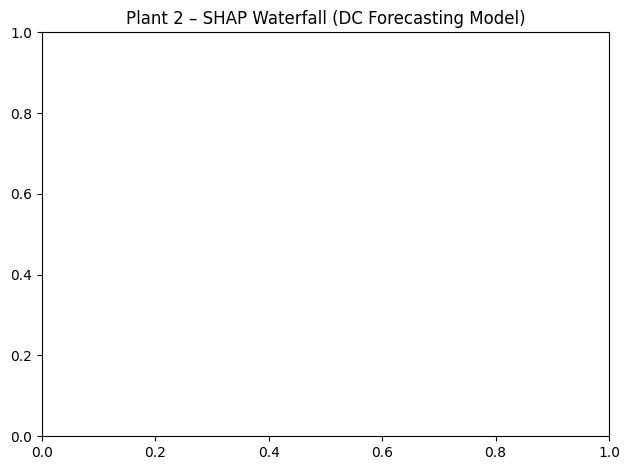

Computing SHAP values for AC model...


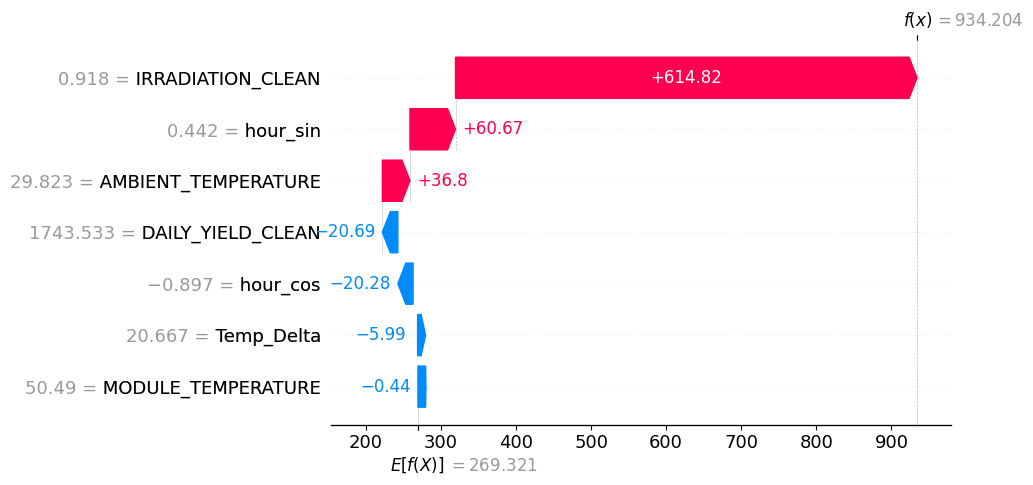

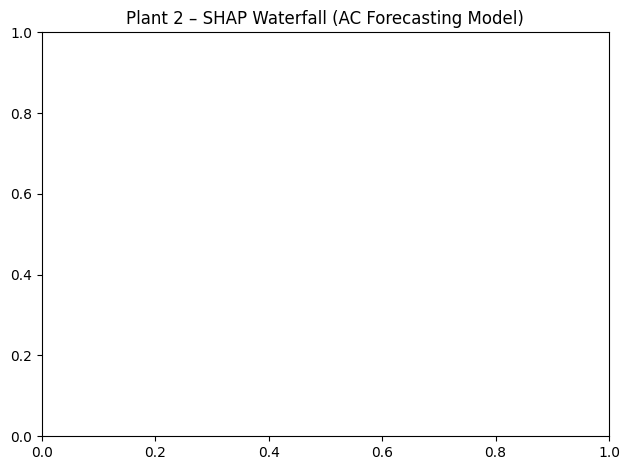

In [5]:
# -----------------------------
# Plant 2 – load and features
# -----------------------------
print("\n=== PLANT 2: Load & combine all inverters ===")
df_p2 = load_all_plant(BASE_DAILY_FOLDER_P2, plant_name="Plant 2")

print("\n=== PLANT 2: Feature engineering ===")
X_p2, y_dc_p2, y_ac_p2, feat_cols_p2 = engineer_features(df_p2, plant_name="Plant 2")

print("\n=== PLANT 2: Train/test split (shared for DC & AC) ===")
X2_train, X2_test, y2_dc_train, y2_dc_test, y2_ac_train, y2_ac_test = train_test_split(
    X_p2, y_dc_p2, y_ac_p2, test_size=0.2, random_state=42
)

# -----------------------------
# Plant 2 – DC model
# -----------------------------
print("\n=== PLANT 2: Train Random Forest – DC_CLEAN ===")
rf_dc_p2 = train_rf(X2_train, y2_dc_train)
print(f"Plant 2 DC model Test R²: {rf_dc_p2.score(X2_test, y2_dc_test):.4f}")

print("\n=== PLANT 2: Permutation importance – DC ===")
permutation_importance_plot(
    rf_dc_p2, X2_test, y2_dc_test, feat_cols_p2,
    "DC Forecasting (Plant 2, all inverters)"
)

# -----------------------------
# Plant 2 – AC model
# -----------------------------
print("\n=== PLANT 2: Train Random Forest – AC_CLEAN ===")
rf_ac_p2 = train_rf(X2_train, y2_ac_train)
print(f"Plant 2 AC model Test R²: {rf_ac_p2.score(X2_test, y2_ac_test):.4f}")

print("\n=== PLANT 2: Permutation importance – AC ===")
permutation_importance_plot(
    rf_ac_p2, X2_test, y2_ac_test, feat_cols_p2,
    "AC Forecasting (Plant 2, all inverters)"
)

# -----------------------------
# Plant 2 – SHAP only (no residual coefficients needed if not required)
# -----------------------------
shap_waterfall_plots(rf_dc_p2, rf_ac_p2, X2_test, feat_cols_p2, plant_label="Plant 2")


# 7. PDP coefficients



In [6]:
def pdp_coefficients(model, X, feature_names, grid_resolution=20,
                     max_samples=5000, random_state=42):
    """
    Compute a simple 'coefficient-like' slope for each feature using
    partial dependence (PDP), similar to Task5_RF_PDP_Coefficients_Plant1_Plant2.py.
    """
    rng = np.random.RandomState(random_state)

    # Downsample X for speed if needed
    if len(X) > max_samples:
        idx = rng.choice(len(X), size=max_samples, replace=False)
        X_used = X.iloc[idx].copy()
    else:
        X_used = X.copy()

    rows = []

    for j, name in enumerate(feature_names):
        print(f"  [PDP] Computing for feature: {name}")
        pd_res = partial_dependence(
            estimator=model,
            X=X_used,
            features=[j],
            kind="average",
            grid_resolution=grid_resolution,
        )

        # sklearn >= 1.2 uses 'grid_values', older used 'values'
        if "grid_values" in pd_res:
            grid = pd_res["grid_values"][0]
        elif "values" in pd_res:
            grid = pd_res["values"][0]
        else:
            raise KeyError(f"No grid values found in partial_dependence result for {name}")

        avg = pd_res["average"][0]   # shape: (grid_resolution,)

        x_min, x_max = float(grid[0]), float(grid[-1])
        y_min, y_max = float(avg[0]), float(avg[-1])

        if x_max == x_min:
            slope = np.nan
        else:
            slope = (y_max - y_min) / (x_max - x_min)

        rows.append({
            "feature": name,
            "pdp_slope": slope,
            "abs_pdp_slope": abs(slope),
        })

    coef_df = (
        pd.DataFrame(rows)
        .set_index("feature")
        .sort_values("abs_pdp_slope", ascending=False)
    )
    return coef_df


# Plot PDP coefficients

  [PDP] Computing for feature: IRRADIATION_CLEAN
  [PDP] Computing for feature: AMBIENT_TEMPERATURE
  [PDP] Computing for feature: MODULE_TEMPERATURE
  [PDP] Computing for feature: Temp_Delta
  [PDP] Computing for feature: DAILY_YIELD_CLEAN
  [PDP] Computing for feature: hour_cos
  [PDP] Computing for feature: hour_sin
  [PDP] Computing for feature: IRRADIATION_CLEAN
  [PDP] Computing for feature: AMBIENT_TEMPERATURE
  [PDP] Computing for feature: MODULE_TEMPERATURE
  [PDP] Computing for feature: Temp_Delta
  [PDP] Computing for feature: DAILY_YIELD_CLEAN
  [PDP] Computing for feature: hour_cos
  [PDP] Computing for feature: hour_sin
  [PDP] Computing for feature: IRRADIATION_CLEAN
  [PDP] Computing for feature: AMBIENT_TEMPERATURE
  [PDP] Computing for feature: MODULE_TEMPERATURE
  [PDP] Computing for feature: Temp_Delta
  [PDP] Computing for feature: DAILY_YIELD_CLEAN
  [PDP] Computing for feature: hour_cos
  [PDP] Computing for feature: hour_sin
  [PDP] Computing for feature: IRRADI

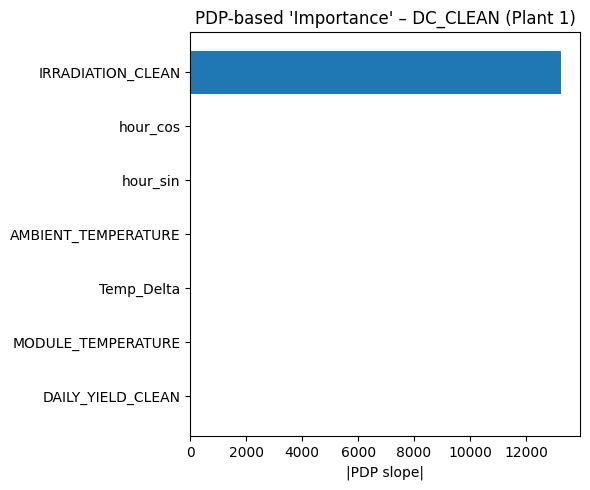

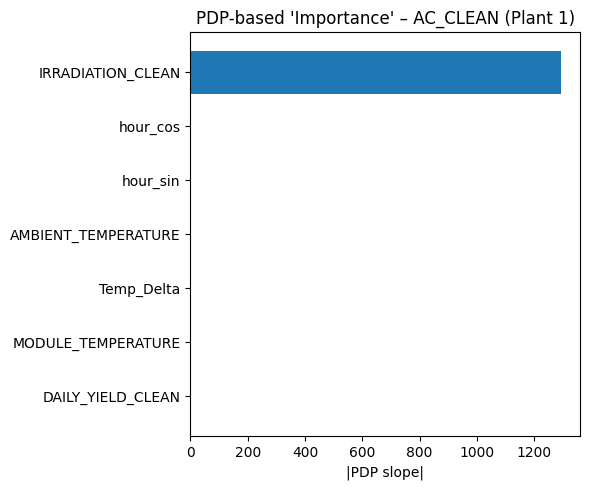

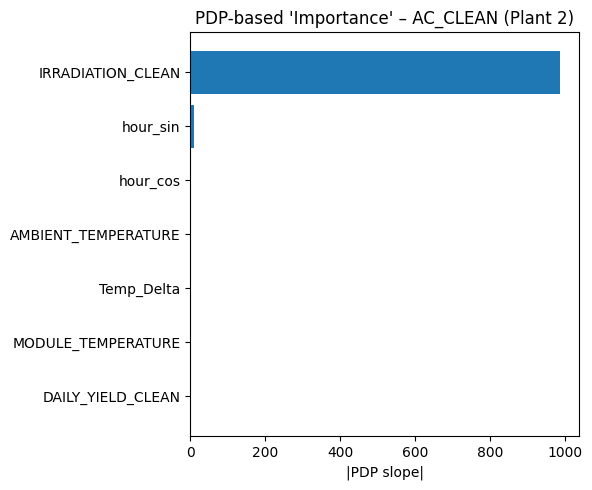

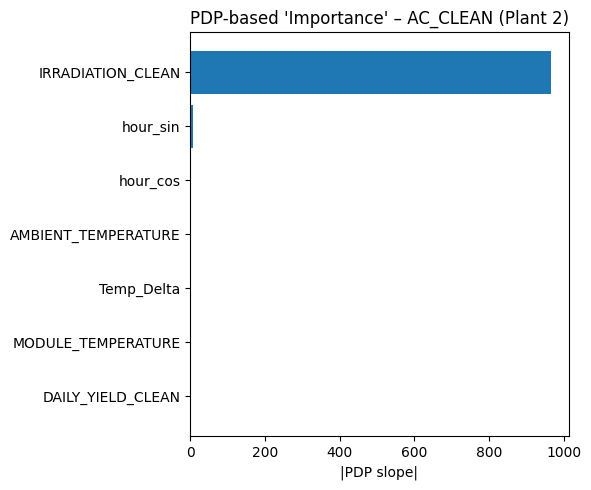

In [7]:
# ----- PDP coefficients – Plant 1 DC and AC -----

coef_pdp_dc_p1 = pdp_coefficients(rf_dc_p1, X_p1, feat_cols_p1)
coef_pdp_ac_p1 = pdp_coefficients(rf_ac_p1, X_p1, feat_cols_p1)
# ----- PDP coefficients – Plant 2 DC and AC -----
coef_pdp_dc_p2 = pdp_coefficients(rf_dc_p2, X_p2, feat_cols_p2)
coef_pdp_ac_p2 = pdp_coefficients(rf_ac_p2, X_p2, feat_cols_p2)

# Bar plot – DC (Plant 1)
plt.figure(figsize=(6, 5))
coef_dc_sorted_p1 = coef_pdp_dc_p1.sort_values("abs_pdp_slope", ascending=True)
plt.barh(coef_dc_sorted_p1.index, coef_dc_sorted_p1["abs_pdp_slope"])
plt.xlabel("|PDP slope|")
plt.title("PDP-based 'Importance' – DC_CLEAN (Plant 1)")
plt.tight_layout()
plt.show()

# Bar plot – AC (Plant 1)
plt.figure(figsize=(6, 5))
coef_ac_sorted_p1 = coef_pdp_ac_p1.sort_values("abs_pdp_slope", ascending=True)
plt.barh(coef_ac_sorted_p1.index, coef_ac_sorted_p1["abs_pdp_slope"])
plt.xlabel("|PDP slope|")
plt.title("PDP-based 'Importance' – AC_CLEAN (Plant 1)")
plt.tight_layout()
plt.show()

# Bar plot – DC (Plant 2)
plt.figure(figsize=(6, 5))
coef_dc_sorted_p2 = coef_pdp_dc_p2.sort_values("abs_pdp_slope", ascending=True)
plt.barh(coef_dc_sorted_p2.index, coef_dc_sorted_p2["abs_pdp_slope"])
plt.xlabel("|PDP slope|")
plt.title("PDP-based 'Importance' – AC_CLEAN (Plant 2)")
plt.tight_layout()
plt.show()

# Bar plot – AC (Plant 2)
plt.figure(figsize=(6, 5))
coef_ac_sorted_p2 = coef_pdp_ac_p2.sort_values("abs_pdp_slope", ascending=True)
plt.barh(coef_ac_sorted_p2.index, coef_ac_sorted_p2["abs_pdp_slope"])
plt.xlabel("|PDP slope|")
plt.title("PDP-based 'Importance' – AC_CLEAN (Plant 2)")
plt.tight_layout()
plt.show()


# PDP for each parameters



=== : PDP curves – DC (Plant 1) ===


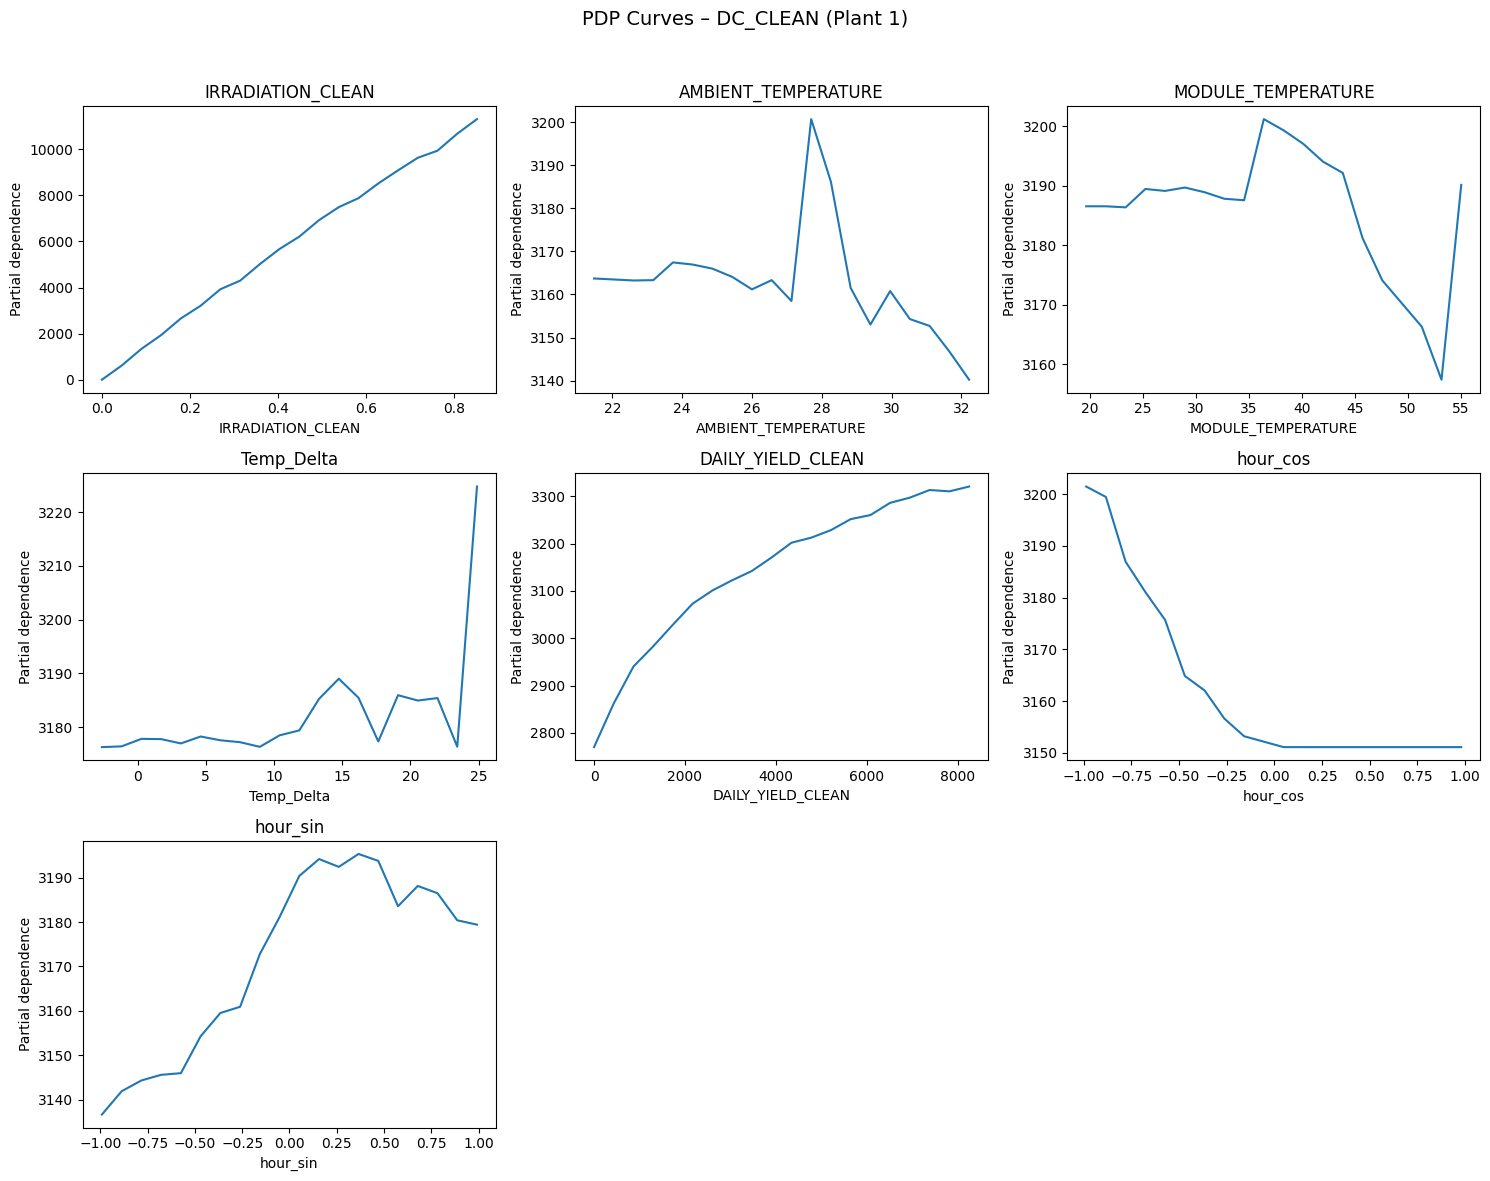


=== : PDP curves – AC (Plant 1) ===


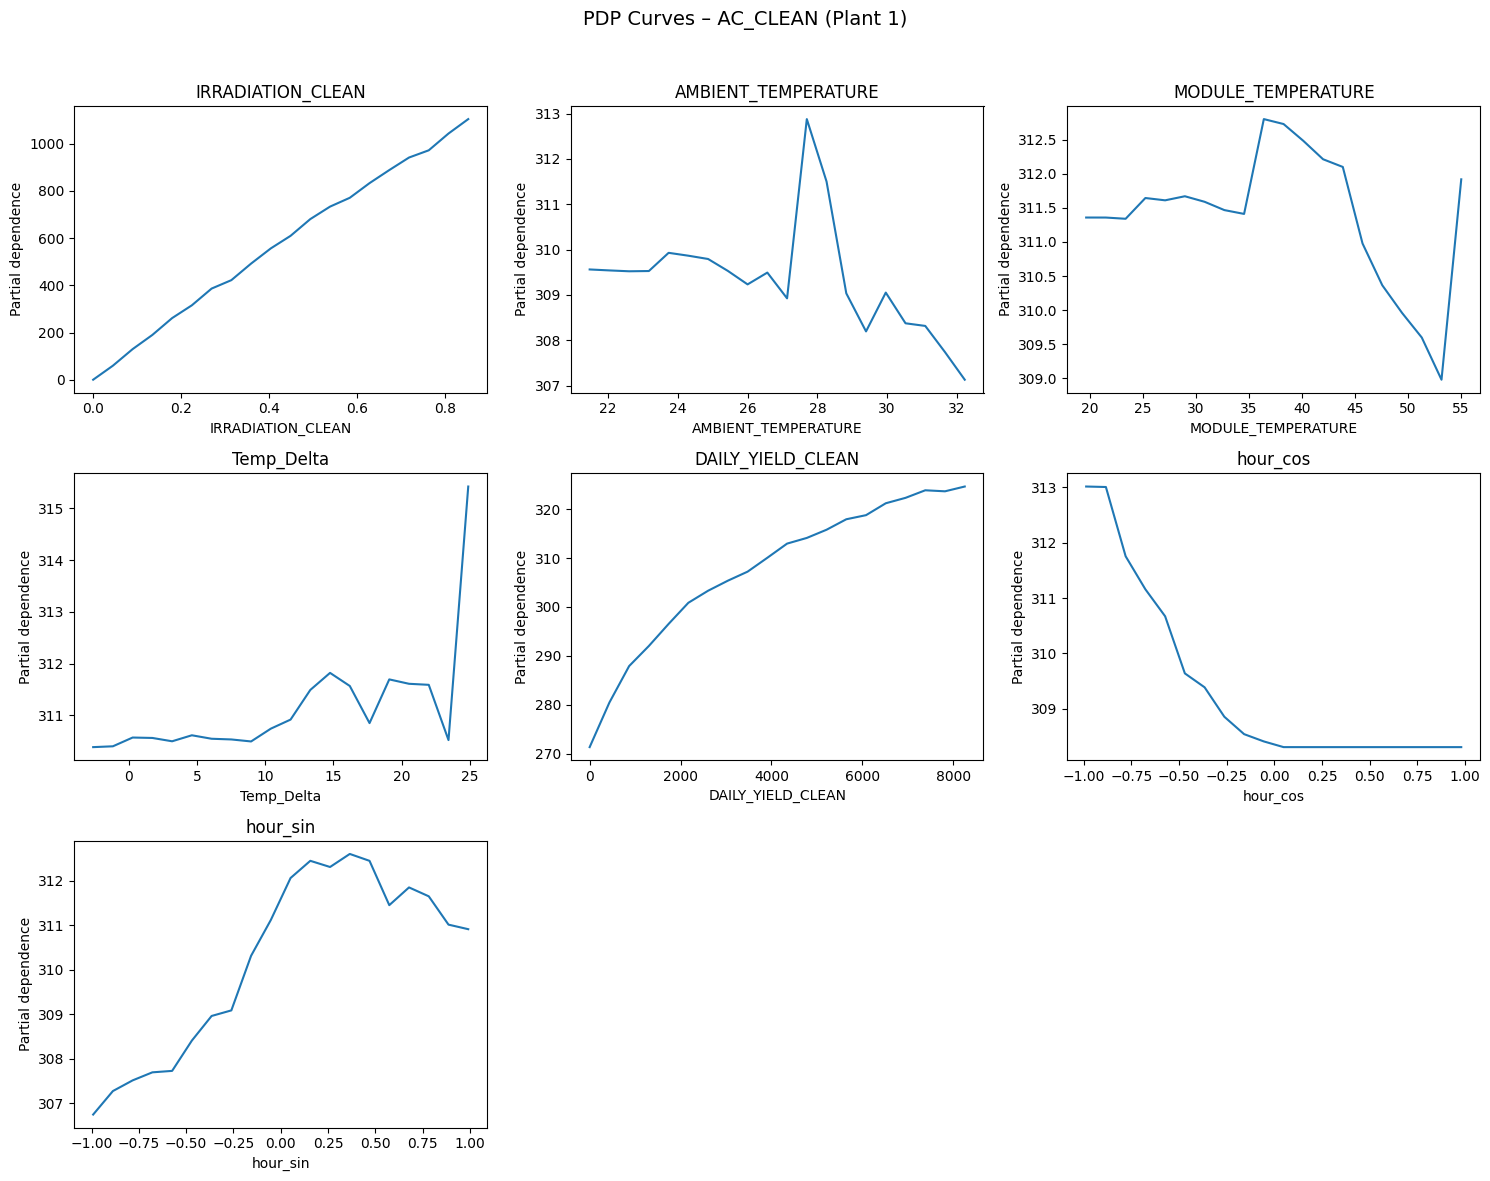


=== PDP curves – DC (Plant 2) ===


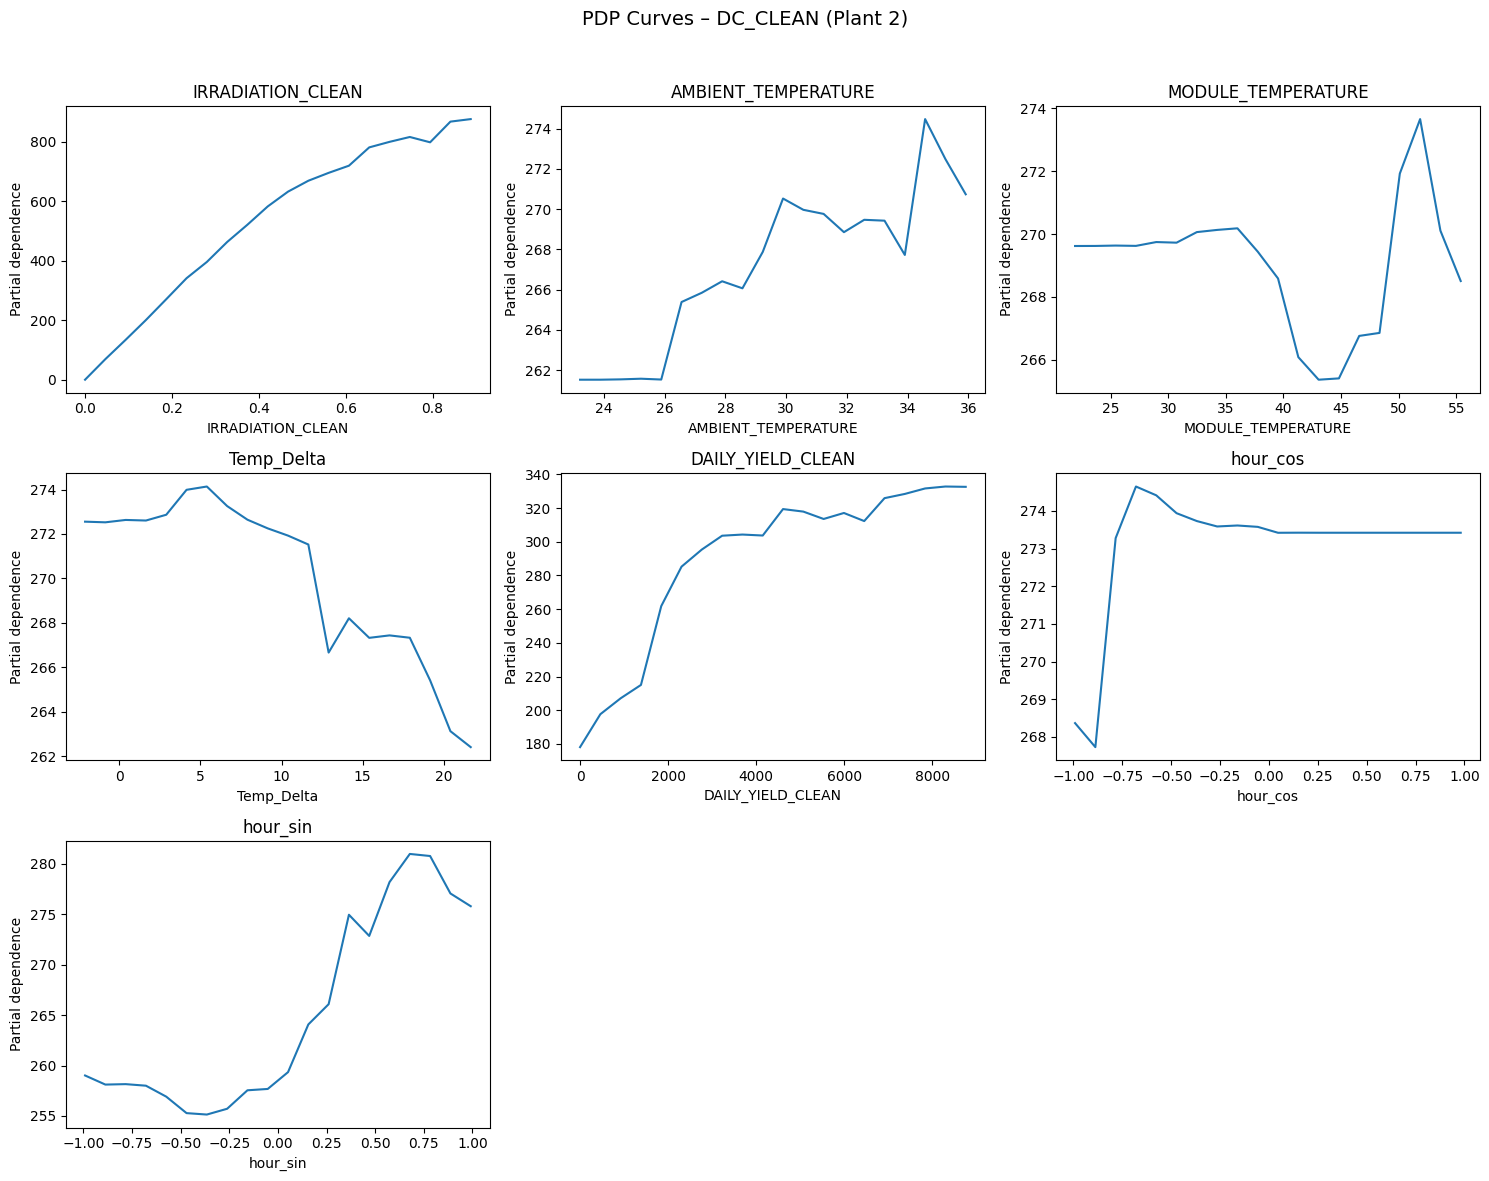


=== PDP curves – AC (Plant 2) ===


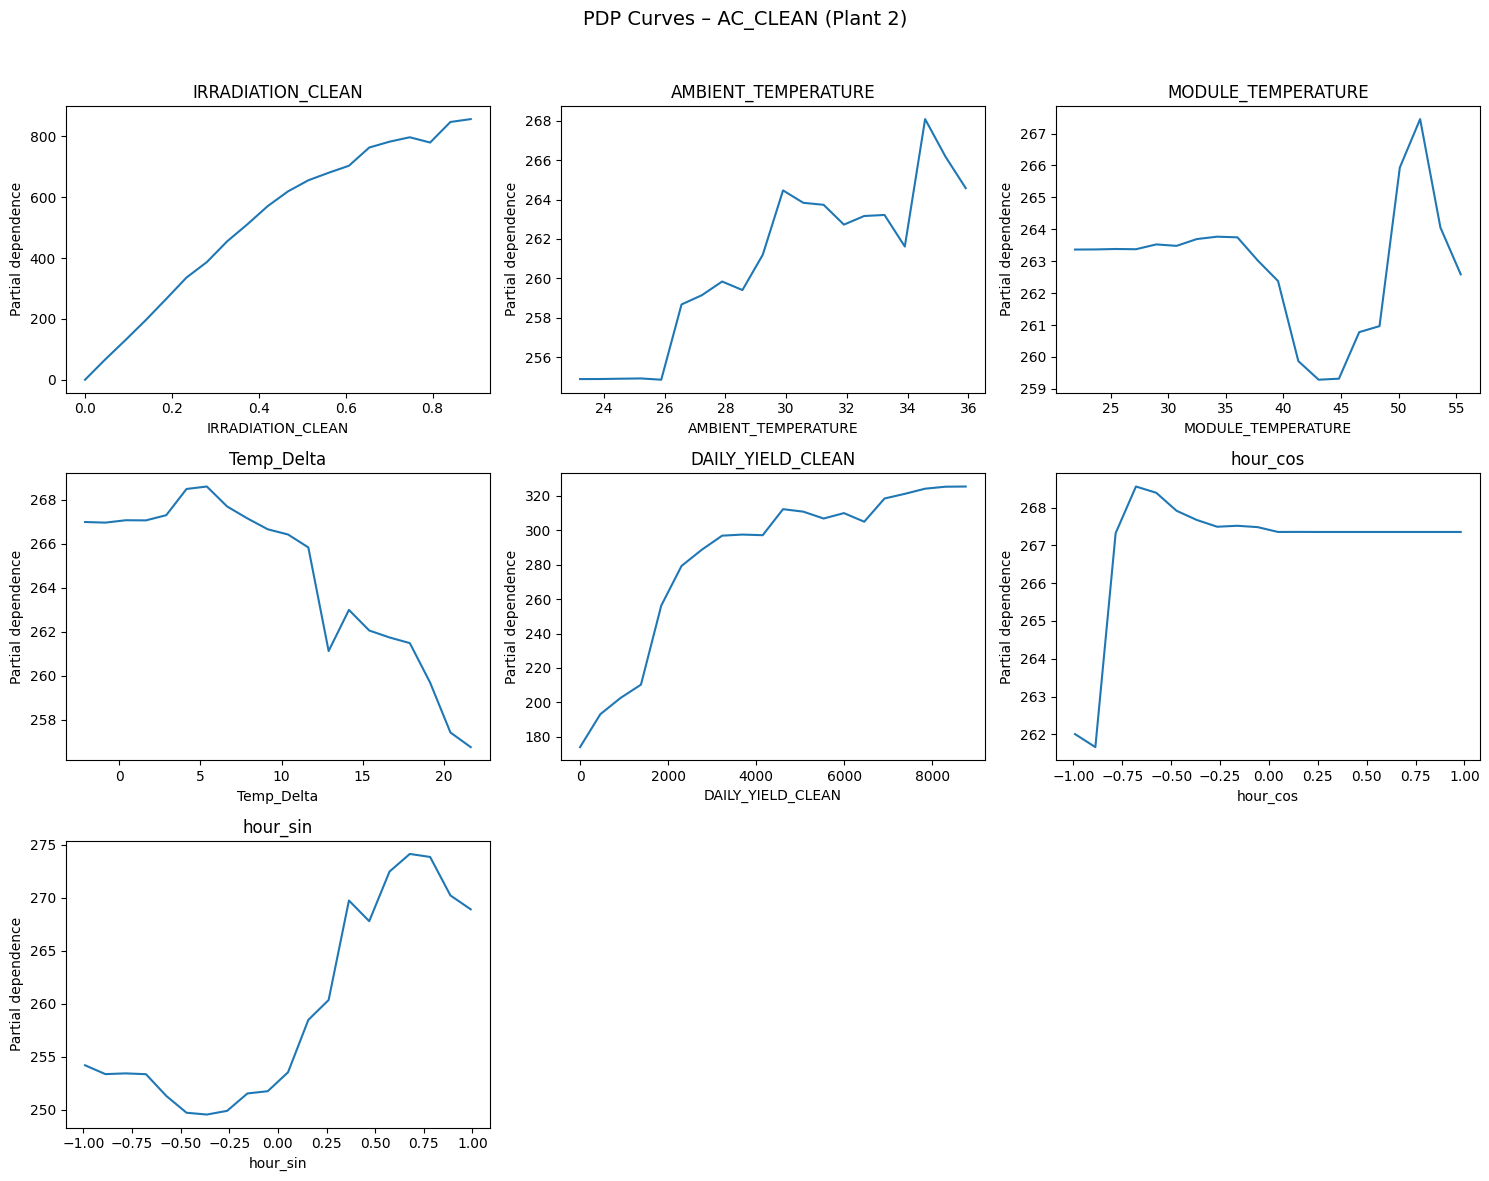

In [8]:
def plot_pdp_grid(model, X, feature_names, title_prefix,
                  grid_resolution=20, max_samples=5000, random_state=42):
    """
    Plot PDP curves for each feature in a grid of subplots.

    x-axis: feature value
    y-axis: average predicted target
    """
    rng = np.random.RandomState(random_state)

    # Downsample X for speed if needed
    if len(X) > max_samples:
        idx = rng.choice(len(X), size=max_samples, replace=False)
        X_used = X.iloc[idx].copy()
    else:
        X_used = X.copy()

    n_feats = len(feature_names)
    n_cols = 3
    n_rows = int(np.ceil(n_feats / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for j, name in enumerate(feature_names):
        ax = axes[j]

        pd_res = partial_dependence(
            estimator=model,
            X=X_used,
            features=[j],
            kind="average",
            grid_resolution=grid_resolution,
        )

        # handle grid_values/values
        if "grid_values" in pd_res:
            grid = pd_res["grid_values"][0]
        else:
            grid = pd_res["values"][0]

        avg = pd_res["average"][0]

        ax.plot(grid, avg)
        ax.set_title(name)
        ax.set_xlabel(name)
        ax.set_ylabel("Partial dependence")

    # Hide any unused subplots
    for k in range(j + 1, len(axes)):
        axes[k].axis("off")

    plt.suptitle(f"PDP Curves – {title_prefix}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # PDP curves for Plant 1 (same style as original code)

plant_name = "Plant 1"

print(f"\n=== : PDP curves – DC ({plant_name}) ===")
plot_pdp_grid(rf_dc_p1, X_p1, feat_cols_p1, title_prefix=f"DC_CLEAN ({plant_name})")

print(f"\n=== : PDP curves – AC ({plant_name}) ===")
plot_pdp_grid(rf_ac_p1, X_p1, feat_cols_p1, title_prefix=f"AC_CLEAN ({plant_name})")

# PDP curves for Plant 2(same style as original code)

plant_name = "Plant 2"

print(f"\n=== PDP curves – DC ({plant_name}) ===")
plot_pdp_grid(rf_dc_p2, X_p2, feat_cols_p2, title_prefix=f"DC_CLEAN ({plant_name})")

print(f"\n=== PDP curves – AC ({plant_name}) ===")
plot_pdp_grid(rf_ac_p2, X_p2, feat_cols_p2, title_prefix=f"AC_CLEAN ({plant_name})")


feature_importance_resultsRF.pkl 
 ├── Plant1
 │    ├── DC
 │    │     ├── permutation_importance → DataFrame
 │    │     ├── residual_coefficients  → DataFrame
 │    │     └── pdp_coefficients       → DataFrame
 │    └── AC
 │          ├── permutation_importance
 │          ├── residual_coefficients
 │          └── pdp_coefficients
 └── Plant2
      ├── DC: permutation_importance + PDP coefficients
      └── AC: permutation_importance + PDP coefficients


In [ ]:
import pickle
import os

# ---------------------------------------------------------
# Create results dictionary following your requested structure
# ---------------------------------------------------------

feature_importance_results = {
    "Plant1": {
        "DC": {
            "permutation_importance": None,      # will fill below
            "residual_coefficients": coef_dc_p1,
            "pdp_coefficients": coef_pdp_dc_p1
        },
        "AC": {
            "permutation_importance": None,
            "residual_coefficients": coef_ac_p1,
            "pdp_coefficients": coef_pdp_ac_p1
        }
    },
    "Plant2": {
        "DC": {
            "permutation_importance": None,
            "pdp_coefficients": coef_pdp_dc_p2
        },
        "AC": {
            "permutation_importance": None,
            "pdp_coefficients": coef_pdp_ac_p2
        }
    }
}

# ---------------------------------------------------------
# Extract permutation importance DataFrames from your plots
# ---------------------------------------------------------
# Modify permutation_importance_plot() earlier to *return* the DataFrame, 
# but since you likely did not, we recompute here.

# --- Plant 1 DC ---
pi_dc_p1 = permutation_importance(
    rf_dc_p1, X1_test, y1_dc_test, n_repeats=20,
    scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
feature_importance_results["Plant1"]["DC"]["permutation_importance"] = \
    pd.DataFrame({
        "feature": feat_cols_p1,
        "importance": pi_dc_p1.importances_mean
    }).sort_values("importance", ascending=False)

# --- Plant 1 AC ---
pi_ac_p1 = permutation_importance(
    rf_ac_p1, X1_test, y1_ac_test, n_repeats=20,
    scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
feature_importance_results["Plant1"]["AC"]["permutation_importance"] = \
    pd.DataFrame({
        "feature": feat_cols_p1,
        "importance": pi_ac_p1.importances_mean
    }).sort_values("importance", ascending=False)

# --- Plant 2 DC ---
pi_dc_p2 = permutation_importance(
    rf_dc_p2, X2_test, y2_dc_test, n_repeats=20,
    scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
feature_importance_results["Plant2"]["DC"]["permutation_importance"] = \
    pd.DataFrame({
        "feature": feat_cols_p2,
        "importance": pi_dc_p2.importances_mean
    }).sort_values("importance", ascending=False)

# --- Plant 2 AC ---
pi_ac_p2 = permutation_importance(
    rf_ac_p2, X2_test, y2_ac_test, n_repeats=20,
    scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
feature_importance_results["Plant2"]["AC"]["permutation_importance"] = \
    pd.DataFrame({
        "feature": feat_cols_p2,
        "importance": pi_ac_p2.importances_mean
    }).sort_values("importance", ascending=False)

# ---------------------------------------------------------
# Save final results dictionary to pickle file
# ---------------------------------------------------------
##################################################################################################################################################################################

# Save path

save_path = r"C:\Users\B.KING\OneDrive - Imperial College London\CIVE70111 Machine Learning\CouseWork\Group-11\data\04 AC DC"

##################################################################################################################################################################################
os.makedirs(save_path, exist_ok=True)

output_file = os.path.join(save_path, "feature_importance_resultsRF.pkl")

with open(output_file, "wb") as f:
    pickle.dump(feature_importance_results, f)

print(f"\n[INFO] Feature importance results saved to:\n{output_file}")



[INFO] Feature importance results saved to:
C:\Users\B.KING\OneDrive - Imperial College London\CIVE70111 Machine Learning\CouseWork\Group-11\data\04 AC DC\feature_importance_resultsRF.pkl


# 8. Summary and Discussion

In this notebook we:

- Combined all inverters for **Plant 1** and **Plant 2** into plant-level datasets.
- Engineered a consistent set of features:
  - `IRRADIATION_CLEAN`
  - ambient / module temperatures and `Temp_Delta`
  - daily and total yields
  - `NUM_OPT`, `NUM_SUBOPT`
  - cyclical time-of-day (`hour_sin`, `hour_cos`).
- Trained **RandomForestRegressor** models for both **DC** and **AC** power for each plant.
- Evaluated the models using **test R²** and **permutation importance**.
- Used **SHAP waterfall plots** to interpret individual predictions.
- Computed:
  - **Residualisation-based coefficients** (approximate marginal effects given other features),
  - (Optional) **PDP-based slopes** as a global measure of feature effect.

These results provide both good predictive performance and physical interpretability, and
extend the classification work in Task 4 to a regression setting for PV plant outputs.
